In [1]:
#import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import numpy.random as rnd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
reviews_df=pd.read_csv('Desktop/state-historic-sites.csv')
reviews_df.head()


,Name,Category,Region,County,Facility URL,Longitude,Latitude,Location,NYS Municipal Boundaries,New York Zip Codes,Counties
0,Schuyler Mansion,State Historic Site,11,Albany,{'url': 'http://nysparks.com/historic-sites/33...,-73.759287,42.641323,"{'latitude': '42.6413229736', 'longitude': '-7...",814,39,2030
1,Clermont,State Historic Site,7,Col/Dutch,{'url': 'http://nysparks.com/historic-sites/16...,-73.911040,42.083310,"{'latitude': '42.0833097387', 'longitude': '-7...",522,970,619
2,Olana,State Historic Site,7,Columbia,{'url': 'http://nysparks.com/historic-sites/23...,-73.828760,42.214595,"{'latitude': '42.2145951381', 'longitude': '-7...",517,977,619
3,John Burroughs Memorial,State Historic Site,5,Delaware,{'url': 'http://nysparks.com/historic-sites/3/...,-74.585969,42.294742,"{'latitude': '42.2947419755', 'longitude': '-7...",559,266,2039
4,Staatsburgh,State Historic Site,7,Dutchess,{'url': 'http://nysparks.com/historic-sites/25...,-73.929949,41.856628,"{'latitude': '41.8566275388', 'longitude': '-7...",595,1011,2040


In [5]:
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin

In [6]:
rnd.seed(42)

In [7]:
reviews_df.shape

(35, 11)

In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 11 columns):
Name                        35 non-null object
Category                    35 non-null object
Region                      35 non-null int64
County                      35 non-null object
Facility URL                33 non-null object
Longitude                   35 non-null float64
Latitude                    35 non-null float64
Location                    35 non-null object
NYS Municipal Boundaries    35 non-null int64
New York Zip Codes          35 non-null int64
Counties                    35 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 3.1+ KB


In [9]:
reviews_df['Facility URL'].value_counts()

{'url': 'http://nysparks.com/historic-sites/2/details.aspx'}     1
{'url': 'http://nysparks.com/historic-sites/21/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/10/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/23/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/5/details.aspx'}     1
{'url': 'http://nysparks.com/historic-sites/35/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/1/details.aspx'}     1
{'url': 'http://nysparks.com/historic-sites/30/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/18/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/16/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/14/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/19/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/11/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/33/details.aspx'}    1
{'url': 'http://nysparks.com/historic-sites/3/details.aspx'}  

In [10]:
reviews_df.describe()

,Region,Longitude,Latitude,NYS Municipal Boundaries,New York Zip Codes,Counties
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,7.457143,-74.712387,42.478978,625.628571,799.628571,1859.400000
std,2.842357,1.468916,0.911058,298.635631,515.971960,571.960313
min,1.000000,-79.063114,40.817175,107.000000,31.000000,619.000000
25%,5.000000,-75.053243,41.599035,427.500000,270.500000,2040.000000
50%,8.000000,-74.018884,42.793733,595.000000,987.000000,2131.000000
75%,10.500000,-73.893495,43.020420,889.000000,1236.000000,2135.500000
max,11.000000,-73.302251,44.249575,1020.000000,1615.000000,2185.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000126FEE5C50>,
      dtype=object)

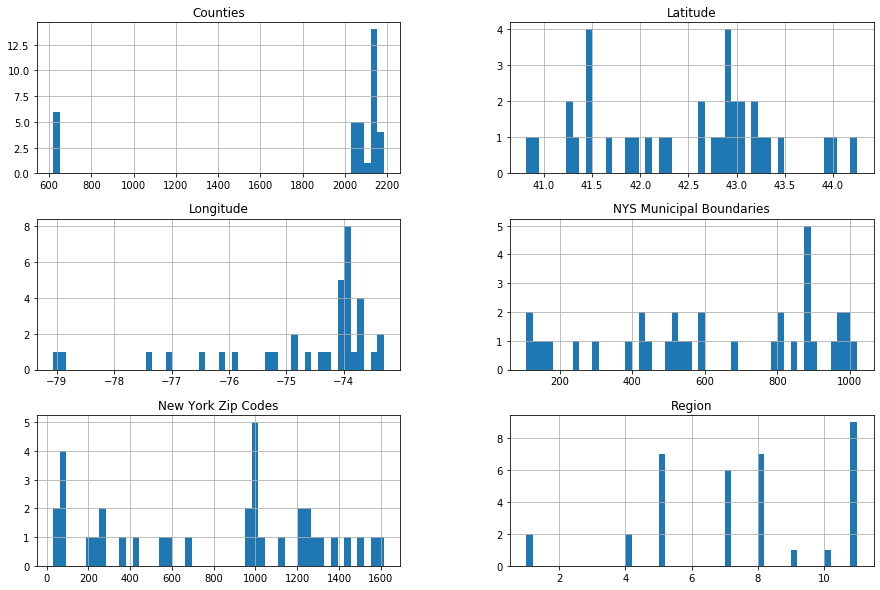

In [11]:
reviews_df.hist(bins=50,figsize=(15,10))

In [12]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(reviews_df, 0.2)
print(len(train_set), "train +", len(test_set), "test")

28 train + 7 test


In [14]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [16]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [17]:
test_set.head()

,Name,Category,Region,County,Facility URL,Longitude,Latitude,Location,NYS Municipal Boundaries,New York Zip Codes,Counties
26,Hyde Hall,State Historic Site,5,Otsego,{'url': 'http://nysparks.com/historic-sites/11...,-74.873997,42.793733,"{'latitude': '42.7937333296', 'longitude': '-7...",898,540,2136
13,Schoharie Crossing,State Historic Site,11,Montgomery,{'url': 'http://nysparks.com/historic-sites/27...,-74.267570,42.949345,"{'latitude': '42.9493448538', 'longitude': '-7...",493,1218,624
24,Washington's Headquarters,State Historic Site,8,Orange,{'url': 'http://nysparks.com/historic-sites/17...,-74.009608,41.497705,"{'latitude': '41.4977050471', 'longitude': '-7...",891,987,2134
21,New Windsor Cantonement,State Historic Site,8,Orange,{'url': 'http://nysparks.com/historic-sites/22...,-74.059457,41.473393,"{'latitude': '41.4733927813', 'longitude': '-7...",889,988,2134
15,Steuben Memorial,State Historic Site,5,Oneida,{'url': 'http://nysparks.com/historic-sites/2/...,-75.232489,43.338106,"{'latitude': '43.3381056996', 'longitude': '-7...",986,1364,625


In [18]:
from sklearn.model_selection import train_test_split   #HELPS US TO SPLIT THE DATASET INTO MULTIPLE COLS.

train_set, test_set = train_test_split(reviews_df, test_size=0.2, random_state=42)

In [19]:
test_set.head()

,Name,Category,Region,County,Facility URL,Longitude,Latitude,Location,NYS Municipal Boundaries,New York Zip Codes,Counties
26,Hyde Hall,State Historic Site,5,Otsego,{'url': 'http://nysparks.com/historic-sites/11...,-74.873997,42.793733,"{'latitude': '42.7937333296', 'longitude': '-7...",898,540,2136
13,Schoharie Crossing,State Historic Site,11,Montgomery,{'url': 'http://nysparks.com/historic-sites/27...,-74.267570,42.949345,"{'latitude': '42.9493448538', 'longitude': '-7...",493,1218,624
24,Washington's Headquarters,State Historic Site,8,Orange,{'url': 'http://nysparks.com/historic-sites/17...,-74.009608,41.497705,"{'latitude': '41.4977050471', 'longitude': '-7...",891,987,2134
21,New Windsor Cantonement,State Historic Site,8,Orange,{'url': 'http://nysparks.com/historic-sites/22...,-74.059457,41.473393,"{'latitude': '41.4733927813', 'longitude': '-7...",889,988,2134
15,Steuben Memorial,State Historic Site,5,Oneida,{'url': 'http://nysparks.com/historic-sites/2/...,-75.232489,43.338106,"{'latitude': '43.3381056996', 'longitude': '-7...",986,1364,625


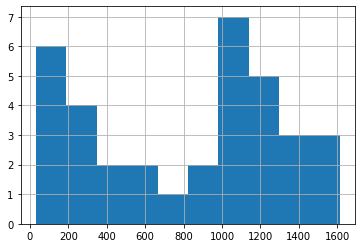

In [20]:
reviews_df["New York Zip Codes"].hist()

In [21]:
reviews_df["New York Zip Codes"].value_counts() / len(reviews_df)

988     0.085714
540     0.028571
977     0.028571
987     0.028571
1562    0.028571
1238    0.028571
1364    0.028571
275     0.028571
1234    0.028571
1615    0.028571
413     0.028571
78      0.028571
970     0.028571
70      0.028571
1218    0.028571
1281    0.028571
220     0.028571
1441    0.028571
1021    0.028571
31      0.028571
1121    0.028571
354     0.028571
93      0.028571
667     0.028571
39      0.028571
1309    0.028571
233     0.028571
1254    0.028571
1492    0.028571
1011    0.028571
570     0.028571
266     0.028571
79      0.028571
Name: New York Zip Codes, dtype: float64

In [22]:
corr_matrix = reviews_df.corr()

In [23]:
corr_matrix["NYS Municipal Boundaries"].sort_values(ascending=False)

NYS Municipal Boundaries    1.000000
New York Zip Codes          0.306741
Longitude                   0.196116
Region                     -0.032088
Counties                   -0.052997
Latitude                   -0.380460
Name: NYS Municipal Boundaries, dtype: float64

NameError: name 'save_fig' is not defined

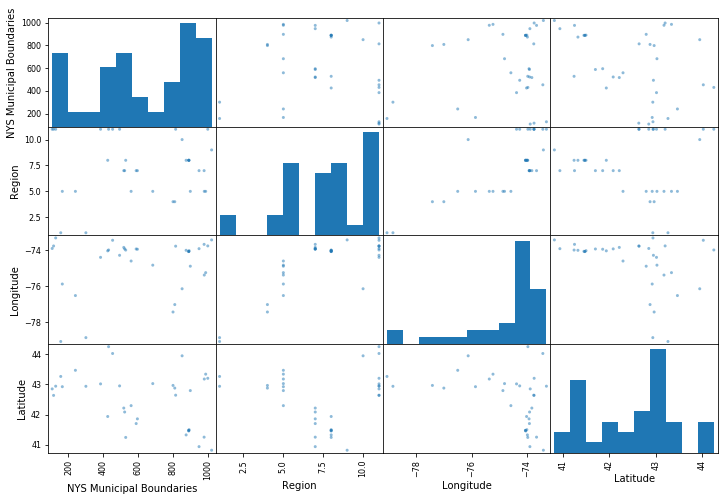

In [24]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["NYS Municipal Boundaries", "Region", "Longitude",
              "Latitude"]
scatter_matrix(reviews_df[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

NameError: name 'save_fig' is not defined

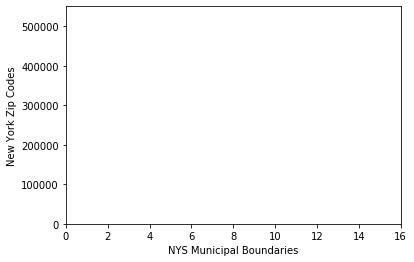

In [25]:
reviews_df.plot(kind="scatter", x="NYS Municipal Boundaries", y="New York Zip Codes",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("NYS Municipal Boundaries_vs_New York Zip Codes_scatterplot")

In [26]:
corr_matrix = reviews_df.corr()
corr_matrix["New York Zip Codes"].sort_values(ascending=False)

New York Zip Codes          1.000000
Longitude                   0.353676
NYS Municipal Boundaries    0.306741
Region                      0.231932
Counties                   -0.365689
Latitude                   -0.399854
Name: New York Zip Codes, dtype: float64

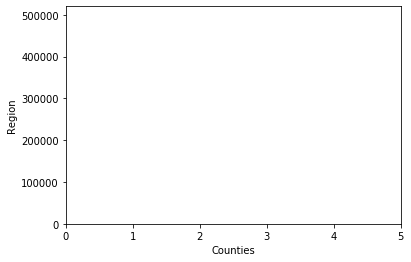

In [27]:
reviews_df.plot(kind="scatter", x="Counties", y="Region",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [28]:
reviews_df.describe()

,Region,Longitude,Latitude,NYS Municipal Boundaries,New York Zip Codes,Counties
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,7.457143,-74.712387,42.478978,625.628571,799.628571,1859.400000
std,2.842357,1.468916,0.911058,298.635631,515.971960,571.960313
min,1.000000,-79.063114,40.817175,107.000000,31.000000,619.000000
25%,5.000000,-75.053243,41.599035,427.500000,270.500000,2040.000000
50%,8.000000,-74.018884,42.793733,595.000000,987.000000,2131.000000
75%,10.500000,-73.893495,43.020420,889.000000,1236.000000,2135.500000
max,11.000000,-73.302251,44.249575,1020.000000,1615.000000,2185.000000


In [29]:
sample_incomplete_rows = reviews_df[reviews_df.isnull().any(axis=1)].head()
sample_incomplete_rows

,Name,Category,Region,County,Facility URL,Longitude,Latitude,Location,NYS Municipal Boundaries,New York Zip Codes,Counties
18,Parrot Hall,State Historic Site,4,Ontario,NaN,-77.008814,42.876774,"{'latitude': '42.8767739578', 'longitude': '-7...",809,233,2133
30,Rexford Aqueduct,State Historic Site,11,Sara/Schen,NaN,-73.887676,42.849265,"{'latitude': '42.8492649622', 'longitude': '-7...",107,78,2141
